In [19]:
import jax
import numpyro

numpyro.set_host_device_count(2)
jax.config.update("jax_enable_x64", True)

literature_period = 2.46113408
literature_t0 = 119.522070 + 2457000 - 2454833

# Prior on the flux ratio for Kepler
literature_flux_ratio = (0.354, 0.035)

# RV

## load data

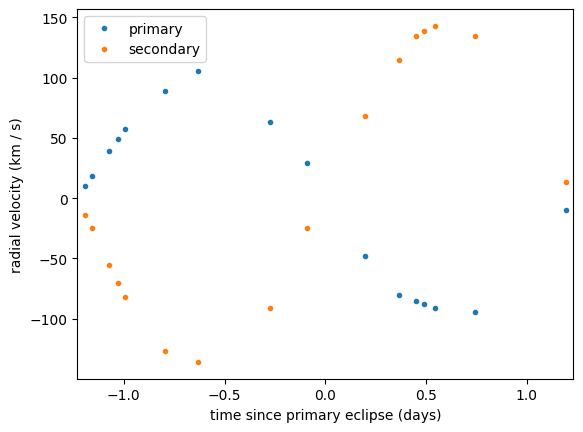

In [20]:
import numpy as np
import matplotlib.pyplot as plt

ref1 = 2453000
ref2 = 2400000
rvs = np.array(
    [
        # https://arxiv.org/abs/astro-ph/0403444
        (39.41273 + ref1, -85.0, 134.5),
        (39.45356 + ref1, -88.0, 139.0),
        (39.50548 + ref1, -91.0, 143.0),
        (43.25049 + ref1, 105.5, -136.0),
        (46.25318 + ref1, 29.5, -24.5),
        # https://ui.adsabs.harvard.edu/abs/2007A%26A...463..579G/abstract
        (52629.6190 + ref2, 88.8, -127.0),
        (52630.6098 + ref2, -48.0, 68.0),
        (52631.6089 + ref2, -9.5, 13.1),
        (52632.6024 + ref2, 63.6, -90.9),
        (52633.6162 + ref2, -94.5, 135.0),
        (52636.6055 + ref2, 10.3, -13.9),
        (52983.6570 + ref2, 18.1, -25.1),
        (52987.6453 + ref2, -80.6, 114.5),
        (52993.6322 + ref2, 49.0, -70.7),
        (53224.9338 + ref2, 39.0, -55.7),
        (53229.9384 + ref2, 57.2, -82.0),
    ]
)
rvs[:, 0] -= 2454833
rvs = rvs[np.argsort(rvs[:, 0])]

time_rvs = np.ascontiguousarray(rvs[:, 0], dtype=np.float64)
obs_rv1 = np.ascontiguousarray(rvs[:, 1], dtype=np.float64)
obs_rv2 = np.ascontiguousarray(rvs[:, 2], dtype=np.float64)

phase_rvs = (
    time_rvs - literature_t0 + 0.5 * literature_period
) % literature_period - 0.5 * literature_period

plt.plot(phase_rvs, rvs[:, 1], ".", label="primary")
plt.plot(phase_rvs, rvs[:, 2], ".", label="secondary")
plt.legend(fontsize=10)
plt.xlim(-0.5 * literature_period, 0.5 * literature_period)
plt.ylabel("radial velocity (km / s)")
_ = plt.xlabel("time since primary eclipse (days)")

## build rv model

In [21]:
from jaxoplanet.orbits import keplerian
import jax.numpy as jnp
from jaxoplanet.units import unit_registry as ureg


def system_model(params):

    # from inferred parameters to system parameters
    R1 = jnp.exp(params["log_R1"]) * ureg.R_sun
    M1 = jnp.exp(params["log_M1"]) * ureg.M_sun
    R2 = jnp.exp(params["log_R1"] + params["log_k"]) * ureg.R_sun
    M2 = jnp.exp(params["log_M1"] + params["log_q"]) * ureg.M_sun
    period = jnp.exp(params["log_period"]) * ureg.day
    t0 = params["t0"] * ureg.day
    eccentricities = params["ecs"]
    eccentricity = jnp.sqrt(jnp.sum(eccentricities**2))
    omega = jnp.arctan2(eccentricities[1], eccentricities[0])
    inclination = params["inclination"] * ureg.rad

    primary = keplerian.Central(radius=R1, mass=M1)

    system = keplerian.System(primary).add_body(
        radius=R2,
        mass=M2,
        period=period,
        time_transit=t0,
        eccentricity=eccentricity,
        omega_peri=omega,
        inclination=inclination,
    )

    return system


def rv_model(time, params):
    system = system_model(params)
    rv = system.radial_velocity(time)[0].to("km / s").magnitude
    mass_ratio = jnp.exp(params["log_q"])
    rv1 = 0 + rv
    rv2 = 0 - rv / mass_ratio
    return rv1, rv2

## bayesian model

In [22]:
from jax import numpy as jnp
import numpyro
from numpyro.distributions import Normal
import numpyro_ext


def model(time, rv1, rv2):
    # Parameters describing the primary
    log_M1 = numpyro.sample("log_M1", Normal(0.0, 10.0))
    log_R1 = numpyro.sample("log_R1", Normal(0.0, 10.0))

    # Secondary ratios
    log_radius_ratio = numpyro.sample("log_k", Normal(0.0, 10.0))  # radius ratio
    log_mass_ratio = numpyro.sample("log_q", Normal(0.0, 10.0))  # mass ratio
    log_flux_ratio = numpyro.sample("log_s", Normal(np.log(0.5), 10.0))  # flux ratio
    numpyro.deterministic("k", jnp.exp(log_radius_ratio))
    numpyro.deterministic("q", jnp.exp(log_mass_ratio))
    numpyro.deterministic("s", jnp.exp(log_flux_ratio))

    # Prior on flux ratio
    numpyro.sample(
        "flux_prior",
        Normal(*literature_flux_ratio),
        obs=jnp.exp(2 * log_radius_ratio + log_flux_ratio),
    )

    # Parameters describing the orbit
    log_period = numpyro.sample("log_period", Normal(np.log(literature_period), 1.0))
    t0 = numpyro.sample("t0", Normal(literature_t0, 200.0))

    # Parameters describing the eccentricity: ecs = [e * cos(w), e * sin(w)]
    ecs = numpyro.sample("ecs", numpyro_ext.distributions.UnitDisk())
    inclination = numpyro.sample("inclination", numpyro_ext.distributions.Angle())

    mean_rv = numpyro.sample("mean_rv", Normal(0.0, 10.0))

    model_params = {
        "log_M1": log_M1,
        "log_R1": log_R1,
        "log_q": log_mass_ratio,
        "log_k": log_radius_ratio,
        "log_period": log_period,
        "log_flux_ratio": log_flux_ratio,
        "inclination": inclination,
        "ecs": ecs,
        "log_s": log_flux_ratio,
        "t0": t0,
    }

    _rv1, _rv2 = rv_model(time, model_params)
    _rv1 += mean_rv
    _rv2 += mean_rv

    numpyro.sample("obs_rv1", numpyro.distributions.Normal(_rv1, 10), obs=rv1)
    numpyro.sample("obs_rv2", numpyro.distributions.Normal(_rv2, 10), obs=rv2)

## optimization

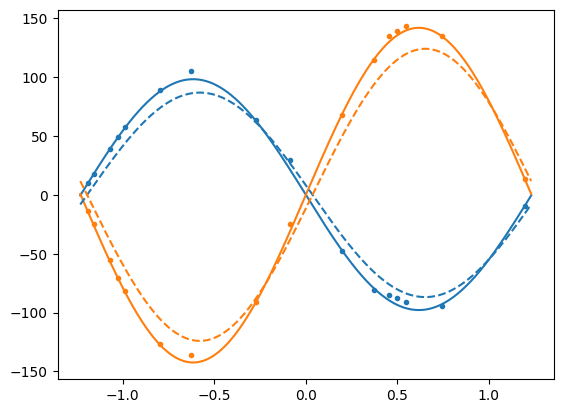

In [23]:
init_values = {
    "log_M1": np.log(1.5),
    "log_R1": np.log(2.0),
    "log_q": np.log(0.7),
    "log_k": np.log(1.0),
    "log_period": np.log(literature_period),
    "log_flux_ratio": np.log(0.5),
    "inclination": 1.365,
    "log_s": np.log(0.354),
    "t0": literature_t0,
    "ecs": np.array([1e-5, 0.0]),
}


opt_params = numpyro_ext.optim.optimize(model, start=init_values)(
    jax.random.PRNGKey(0),
    time_rvs,
    rv1=obs_rv1,
    rv2=obs_rv2,
)

period = jnp.exp(opt_params["log_period"])
t0 = opt_params["t0"]

rv_model_phase = np.linspace(-0.5 * period, 0.5 * period, 500)
mrv1, mrv2 = rv_model(rv_model_phase + t0, opt_params)
_mrv1, _mrv2 = rv_model(rv_model_phase + t0, init_values)

phase_rvs = (time_rvs - t0 + 0.5 * period) % period - 0.5 * period
plt.plot(phase_rvs, rvs[:, 1], ".", color="C0", label="primary")
plt.plot(phase_rvs, rvs[:, 2], ".", color="C1", label="secondary")
plt.plot(rv_model_phase, mrv1, "-", color="C0")
plt.plot(rv_model_phase, mrv2, "-", color="C1")
plt.plot(rv_model_phase, _mrv1, "--", color="C0")
plt.plot(rv_model_phase, _mrv2, "--", color="C1")

## sampling with numpyro NUTS

In [ ]:
from numpyro import infer

sampler = infer.MCMC(
    infer.NUTS(
        model,
        init_strategy=infer.init_to_value(values=opt_params),
        dense_mass=True,
        regularize_mass_matrix=False,
    ),
    num_warmup=200,
    num_samples=2000,
    progress_bar=True,
    num_chains=2,
)

sampler.run(jax.random.PRNGKey(6), time_rvs, obs_rv1, obs_rv2)

## sampling with blackjax NUTS

In [ ]:
from numpyro.infer.util import initialize_model

rng_key = jax.random.PRNGKey(0)
rng_key, init_key = jax.random.split(rng_key)
init_params, potential_fn_gen, *_ = initialize_model(
    init_key,
    model,
    model_args=(time_rvs, obs_rv1, obs_rv2),
    dynamic_args=True,
)

logdensity_fn = lambda position: -potential_fn_gen(time_rvs, obs_rv1, obs_rv2)(position)
initial_position = init_params.z

import blackjax

num_warmup = 2000

adapt = blackjax.window_adaptation(
    blackjax.nuts, logdensity_fn, target_acceptance_rate=0.8
)
rng_key, warmup_key = jax.random.split(rng_key)
(last_state, parameters), _ = adapt.run(warmup_key, initial_position, num_warmup)
kernel = blackjax.nuts(logdensity_fn, **parameters).step


def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, (
        infos.acceptance_rate,
        infos.is_divergent,
        infos.num_integration_steps,
    )


num_sample = 1000
rng_key, sample_key = jax.random.split(rng_key)
states, infos = inference_loop(sample_key, kernel, last_state, num_sample)
_ = states.position["log_M1"].block_until_ready()

In [ ]:
import corner
import arviz

inf_data = arviz.from_dict(
    posterior={k: v[None, ...] for k, v in states.position.items()}
)

In [ ]:
import corner
import arviz

# inf_data = arviz.from_numpyro(sampler)

fig = plt.figure(figsize=(5, 5))
_ = corner.corner(
    inf_data,
    var_names=["log_q", "log_period", "log_M1", "inclination"],
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 10},
    label_kwargs={"fontsize": 10},
    title_fmt=".4f",
    fig=fig,
)

# Light curve
## load data

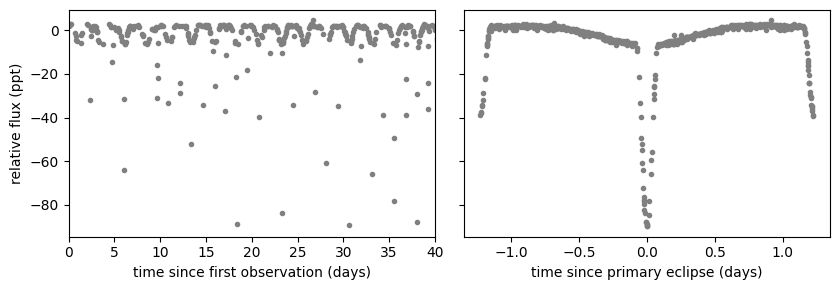

In [265]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk

tpf = lk.search_targetpixelfile("EPIC 211082420").download()
lc = tpf.to_lightcurve(aperture_mask="all")
lc = lc.remove_nans().normalize()

hdr = tpf.hdu[1].header
exposure = hdr["FRAMETIM"] * hdr["NUM_FRM"]
exposure /= 60.0 * 60.0 * 24.0

# To keep things fast for this example, we're only going to use a third of the data
np.random.seed(68594)
m = np.random.rand(len(lc.time)) < 1.0 / 5

time = lc.time.value[m]
flux = lc.flux[m]
flux = flux / np.median(flux) - 1
flux = flux.value * 1e3  # ppt

phase = (
    time - literature_t0 + 0.5 * literature_period
) % literature_period - 0.5 * literature_period

fig, axes = plt.subplots(1, 2, figsize=(8.5, 3), sharey=True)

plt.subplot(121)
plt.plot(time - time.min(), flux, ".", c="0.5")
plt.xlabel("time since first observation (days)")
plt.ylabel("relative flux (ppt)")
plt.xlim(0, 40)

plt.subplot(122)
plt.plot(phase, flux, ".", c="0.5")
plt.xlabel("time since primary eclipse (days)")

plt.tight_layout()

## build light curve model

In [293]:
import jax.numpy as jnp
from jaxoplanet.orbits import keplerian
from jaxoplanet.starry.orbit import SurfaceSystem, Surface
from jaxoplanet.light_curves.emission import light_curve
from jaxoplanet.light_curves.transforms import integrate
from tinygp import GaussianProcess, kernels
from jaxoplanet.units import unit_registry as ureg


def system_model(params):

    # from inferred parameters to system parameters
    R1 = jnp.exp(params["log_R1"]) * ureg.R_sun
    M1 = jnp.exp(params["log_M1"]) * ureg.M_sun
    R2 = jnp.exp(params["log_R1"] + params["log_k"]) * ureg.R_sun
    M2 = jnp.exp(params["log_M1"] + params["log_q"]) * ureg.M_sun
    period = jnp.exp(params["log_period"]) * ureg.day
    t0 = params["t0"] * ureg.day
    eccentricities = params["ecs"]
    eccentricity = jnp.sqrt(jnp.sum(eccentricities**2))
    omega = jnp.arctan2(eccentricities[1], eccentricities[0])
    inclination = params["inclination"] * ureg.rad
    s = jnp.exp(params["log_s"])
    u1 = params["u1"]
    u2 = params["u2"]

    primary = keplerian.Central(radius=R1, mass=M1)
    primary_surface = Surface(u=(u1, u2), amplitude=1.0, normalize=False)
    secondary_surface = Surface(amplitude=s, normalize=False)

    system = SurfaceSystem(primary, primary_surface).add_body(
        radius=R2,
        mass=M2,
        period=period,
        time_transit=t0,
        eccentricity=eccentricity,
        omega_peri=omega,
        inclination=inclination,
        surface=secondary_surface,
    )

    return system


def light_curve_model(time, params):

    system = system_model(params)

    # def flux_function(time):
    #     flux = 1e3 * (
    #         (jnp.sum(integrate(light_curve(system), exposure_time=exposure)(time)))
    #         / (1 + jnp.exp(params["log_s"]))
    #         - 1.0
    #     )

    def flux_function(time):
        flux = (
            1e3
            * (
                (jnp.sum(light_curve(system)(time))) / (1 + jnp.exp(params["log_s"]))
                - 1.0
            )
            + params["mean_lc"]
        )

        return flux

    gp = GaussianProcess(
        kernels.quasisep.SHO(
            sigma=params["lc_gp_sigma"],
            omega=params["lc_gp_omega"],
            quality=params["lc_gp_quality"],
        ),
        time,
        mean=flux_function,
        diag=params["lc_sigma"] ** 2,
    )

    return gp

## bayesian model

In [294]:
from scipy.optimize import root
from scipy.special import gammaincc


def estimate_inverse_gamma_parameters(
    lower, upper, target=0.01, initial=None, **kwargs
):
    r"""Estimate an inverse Gamma with desired tail probabilities
    This method numerically solves for the parameters of an inverse Gamma
    distribution where the tails have a given probability. In other words
    :math:`P(x < \mathrm{lower}) = \mathrm{target}` and similarly for the
    upper bound. More information can be found in `part 4 of this blog post
    <https://betanalpha.github.io/assets/case_studies/gp_part3/part3.html>`_.
    Args:
        lower (float): The location of the lower tail
        upper (float): The location of the upper tail
        target (float, optional): The desired tail probability
        initial (ndarray, optional): An initial guess for the parameters
            ``alpha`` and ``beta``
    Raises:
        RuntimeError: If the solver does not converge.
    Returns:
        dict: A dictionary with the keys ``alpha`` and ``beta`` for the
        parameters of the distribution.
    """
    lower, upper = np.sort([lower, upper])
    if initial is None:
        initial = np.array([2.0, 0.5 * (lower + upper)])
    if np.shape(initial) != (2,) or np.any(np.asarray(initial) <= 0.0):
        raise ValueError("invalid initial guess")

    def obj(x):
        a, b = np.exp(x)
        return np.array(
            [
                gammaincc(a, b / lower) - target,
                1 - gammaincc(a, b / upper) - target,
            ]
        )

    result = root(obj, np.log(initial), method="hybr", **kwargs)
    if not result.success:
        raise RuntimeError(
            "failed to find parameter estimates: \n{0}".format(result.message)
        )
    return dict(zip(("concentration", "rate"), np.exp(result.x)))

In [295]:
from jax import numpy as jnp
import numpyro
from numpyro.distributions import Normal, InverseGamma, Uniform
import numpyro_ext


def model(time, flux):
    # Parameters describing the primary
    log_M1 = numpyro.sample("log_M1", Normal(0.0, 10.0))
    log_R1 = numpyro.sample("log_R1", Normal(0.0, 10.0))
    u1 = numpyro.sample("u1", Uniform(0.0, 1.0))
    u2 = numpyro.sample("u2", Uniform(0.0, 1.0))

    # Secondary ratios
    log_radius_ratio = numpyro.sample("log_k", Normal(0.0, 10.0))  # radius ratio
    log_mass_ratio = numpyro.sample("log_q", Normal(0.0, 10.0))  # mass ratio
    log_flux_ratio = numpyro.sample("log_s", Normal(np.log(0.5), 10.0))  # flux ratio
    numpyro.deterministic("k", jnp.exp(log_radius_ratio))
    numpyro.deterministic("q", jnp.exp(log_mass_ratio))
    numpyro.deterministic("s", jnp.exp(log_flux_ratio))

    R1 = numpyro.deterministic("R1", jnp.exp(log_R1))
    M1 = numpyro.deterministic("M1", jnp.exp(log_M1))
    R2 = numpyro.deterministic("R2", R1 * jnp.exp(log_radius_ratio))
    M2 = numpyro.deterministic("M2", M1 * jnp.exp(log_mass_ratio))

    # Prior on flux ratio
    numpyro.sample(
        "flux_prior",
        Normal(*literature_flux_ratio),
        obs=jnp.exp(2 * log_radius_ratio + log_flux_ratio),
    )

    # Parameters describing the orbit
    log_period = numpyro.sample("log_period", Normal(np.log(literature_period), 1.0))
    t0 = numpyro.sample("t0", Normal(literature_t0, 1.0))

    # Parameters describing the eccentricity: ecs = [e * cos(w), e * sin(w)]
    ecs = numpyro.sample("ecs", numpyro_ext.distributions.UnitDisk())
    inclination = numpyro.sample("inclination", numpyro_ext.distributions.Angle())

    # light curve gp
    lc_gp_omega = numpyro.sample(
        "lc_gp_omega", InverseGamma(**estimate_inverse_gamma_parameters(1.0, 5.0))
    )
    lc_gp_sigma = numpyro.sample(
        "lc_gp_sigma",
        InverseGamma(**estimate_inverse_gamma_parameters(1.0, 5.0)),
    )
    lc_gp_quality = numpyro.deterministic("lc_gp_quality", 1 / 3)

    # error
    lc_sigma = numpyro.sample(
        "lc_sigma", InverseGamma(**estimate_inverse_gamma_parameters(0.1, 2.0))
    )

    mean_lc = numpyro.sample("mean_lc", Normal(0.0, 10.0))

    model_params = {
        "log_M1": log_M1,
        "log_R1": log_R1,
        "log_q": log_mass_ratio,
        "log_k": log_radius_ratio,
        "log_period": log_period,
        "log_flux_ratio": log_flux_ratio,
        "inclination": inclination,
        "ecs": ecs,
        "log_s": log_flux_ratio,
        "t0": t0,
        "u1": u1,
        "u2": u2,
        "lc_gp_sigma": lc_gp_sigma,
        "lc_gp_omega": lc_gp_omega,
        "lc_gp_quality": lc_gp_quality,
        "lc_sigma": lc_sigma,
        "mean_lc": mean_lc,
    }

    gp = light_curve_model(time, model_params)
    numpyro.sample("gp", gp.numpyro_dist(), obs=flux)
    numpyro.deterministic("mean", gp.mean)

## optimize

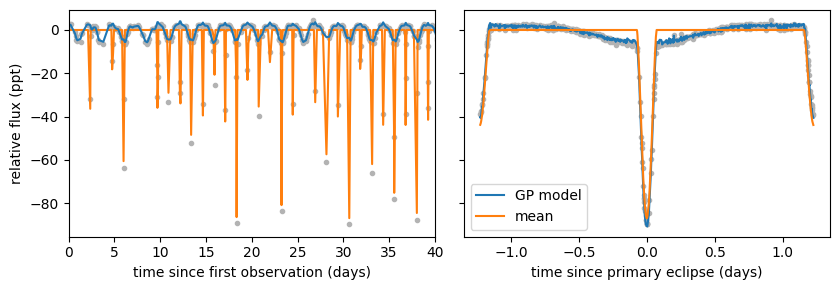

In [296]:
init_values = {
    "log_M1": np.log(2.24),
    "log_R1": np.log(1.758),
    "log_q": np.log(1.570 / 2.24),
    "log_k": np.log(1.508 / 1.758),
    "log_period": np.log(literature_period),
    "inclination": 1.365,
    "log_s": np.log(0.354),
    "t0": literature_t0,
    "ecs": np.array([1e-5, 0.0]),
    "u1": 0.2,
    "u2": 0.2,
    "lc_gp_sigma": 5.0,
    "lc_gp_omega": 5.0,
    "lc_gp_quality": 1 / 3,
    "lc_sigma": 2.0,
    "mean_lc": 0.0,
}

gp = light_curve_model(time, init_values)
phase = (
    time - literature_t0 + 0.5 * literature_period
) % literature_period - 0.5 * literature_period
fig, axes = plt.subplots(1, 2, figsize=(8.5, 3), sharey=True)
idxs = np.argsort(phase)

plt.subplot(121)
plt.plot(time - time.min(), flux, ".", c="0.7")
plt.plot(time - time.min(), gp.mean, label="mean", c="C1")
plt.plot(time - time.min(), gp.condition(flux).gp.loc - gp.mean, c="C0")
plt.xlabel("time since first observation (days)")
plt.ylabel("relative flux (ppt)")
plt.xlim(0, 40)

plt.subplot(122)
plt.plot(phase, flux, ".", c="0.7")
plt.xlabel("time since primary eclipse (days)")
plt.plot(phase[idxs], gp.condition(flux).gp.loc[idxs], c="C0", label="GP model")
plt.plot(phase[idxs], gp.mean[idxs], c="C1", label="mean")
plt.legend()
plt.tight_layout()

In [297]:
opt_params = numpyro_ext.optim.optimize(
    model,
    start=init_values,
    sites=[
        "mean_lc",
        "lc_sigma" "log_R1",
        "log_k",
        "log_s",
        "inclination",
        "u1",
        "u2",
        "ecs",
    ],
)(jax.random.PRNGKey(0), time, flux)

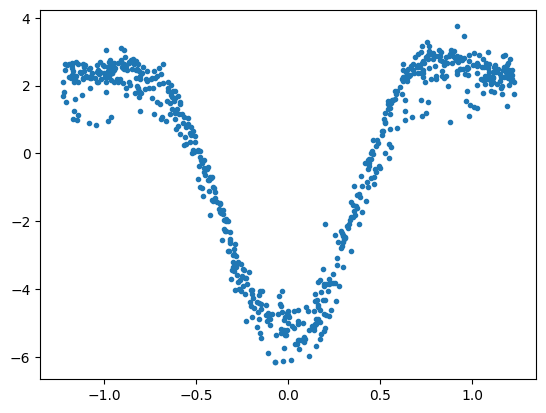

In [298]:
phase_pred = (
    time - opt_params["t0"] + 0.5 * np.exp(opt_params["log_period"])
) % np.exp(opt_params["log_period"]) - 0.5 * np.exp(opt_params["log_period"])

gp = light_curve_model(time, opt_params)
plt.plot(phase_pred[idxs], gp.condition(flux).gp.loc[idxs] - gp.mean[idxs], ".", c="C0")

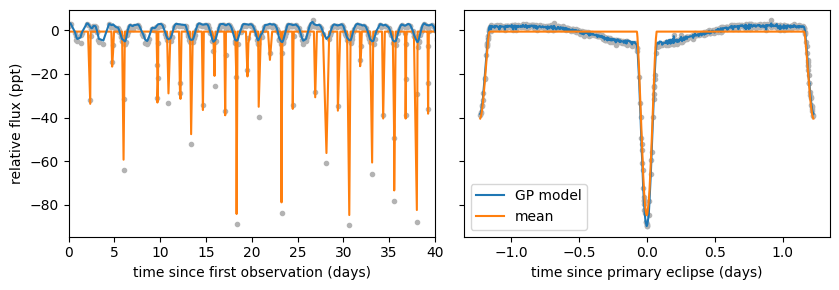

In [299]:
phase_pred = (
    time - opt_params["t0"] + 0.5 * np.exp(opt_params["log_period"])
) % np.exp(opt_params["log_period"]) - 0.5 * np.exp(opt_params["log_period"])

gp = light_curve_model(time, opt_params)

fig, axes = plt.subplots(1, 2, figsize=(8.5, 3), sharey=True)
plt.subplot(121)
plt.plot(time - time.min(), flux, ".", c="0.7")
plt.plot(time - time.min(), gp.mean, label="mean", c="C1")
plt.plot(time - time.min(), gp.condition(flux).gp.loc - gp.mean, c="C0")
plt.xlabel("time since first observation (days)")
plt.ylabel("relative flux (ppt)")
plt.xlim(0, 40)

plt.subplot(122)
plt.plot(phase_pred, flux, ".", c="0.7")
plt.xlabel("time since primary eclipse (days)")
plt.plot(phase_pred[idxs], gp.condition(flux).gp.loc[idxs], c="C0", label="GP model")
plt.plot(phase_pred[idxs], gp.mean[idxs], c="C1", label="mean")
plt.legend()
plt.tight_layout()

In [300]:
from tqdm import tqdm

mask = np.ones(len(time), dtype=bool)
init_2 = opt_params.copy()

for _ in tqdm(range(3)):
    opt_params = numpyro_ext.optim.optimize(
        model,
        start=init_2,
    )(jax.random.PRNGKey(0), time[mask], flux[mask])
    gp = light_curve_model(time[mask], opt_params)
    residuals = np.abs(flux - gp.condition(flux[mask], time).gp.loc)
    mask = mask & (residuals < 7 * np.std(residuals[mask]))

100%|██████████| 3/3 [00:19<00:00,  6.45s/it]


Text(0.5, 0, 'time since primary eclipse (days)')

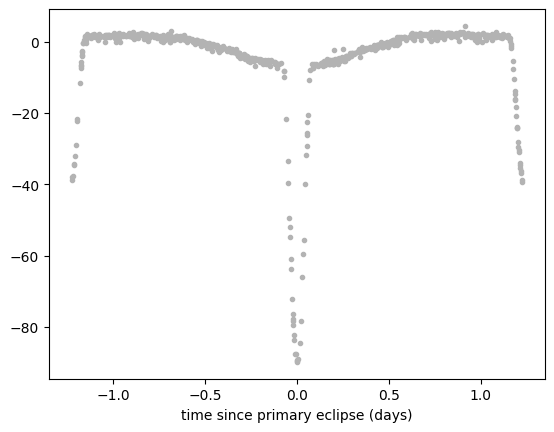

In [301]:
plt.plot(phase, flux, ".", c="0.7")
plt.plot(phase[~mask], flux[~mask], ".", c="C3")
plt.xlabel("time since primary eclipse (days)")

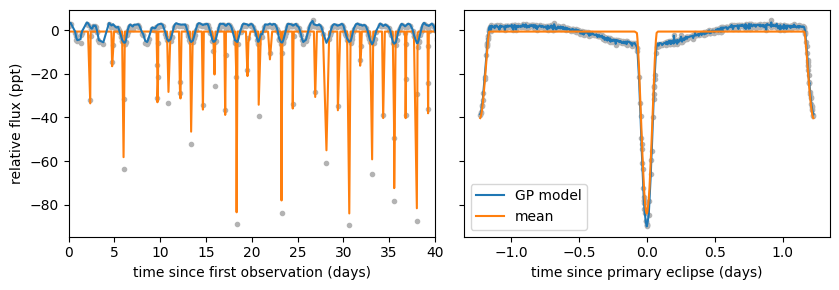

In [302]:
phase_pred = (
    time - opt_params["t0"] + 0.5 * np.exp(opt_params["log_period"])
) % np.exp(opt_params["log_period"]) - 0.5 * np.exp(opt_params["log_period"])

gp = light_curve_model(time, opt_params)

fig, axes = plt.subplots(1, 2, figsize=(8.5, 3), sharey=True)
plt.subplot(121)
plt.plot(time - time.min(), flux, ".", c="0.7")
plt.plot(time - time.min(), gp.mean, label="mean", c="C1")
plt.plot(time - time.min(), gp.condition(flux).gp.loc - gp.mean, c="C0")
plt.xlabel("time since first observation (days)")
plt.ylabel("relative flux (ppt)")
plt.xlim(0, 40)

plt.subplot(122)
plt.plot(phase, flux, ".", c="0.7")
plt.xlabel("time since primary eclipse (days)")
plt.plot(phase[idxs], gp.condition(flux).gp.loc[idxs], c="C0", label="GP model")
plt.plot(phase[idxs], gp.mean[idxs], c="C1", label="mean")
plt.legend()
plt.tight_layout()

## sampling with numpyro NUTS

In [303]:
from numpyro import infer

sampler = infer.MCMC(
    infer.NUTS(
        model,
        init_strategy=infer.init_to_value(values=opt_params),
        dense_mass=True,
        regularize_mass_matrix=False,
    ),
    num_warmup=200,
    num_samples=1000,
    progress_bar=True,
    num_chains=1,
)

sampler.run(jax.random.PRNGKey(6), time, flux)

sample: 100%|██████████| 1200/1200 [13:40<00:00,  1.46it/s, 1023 steps of size 2.46e-02. acc. prob=0.85]


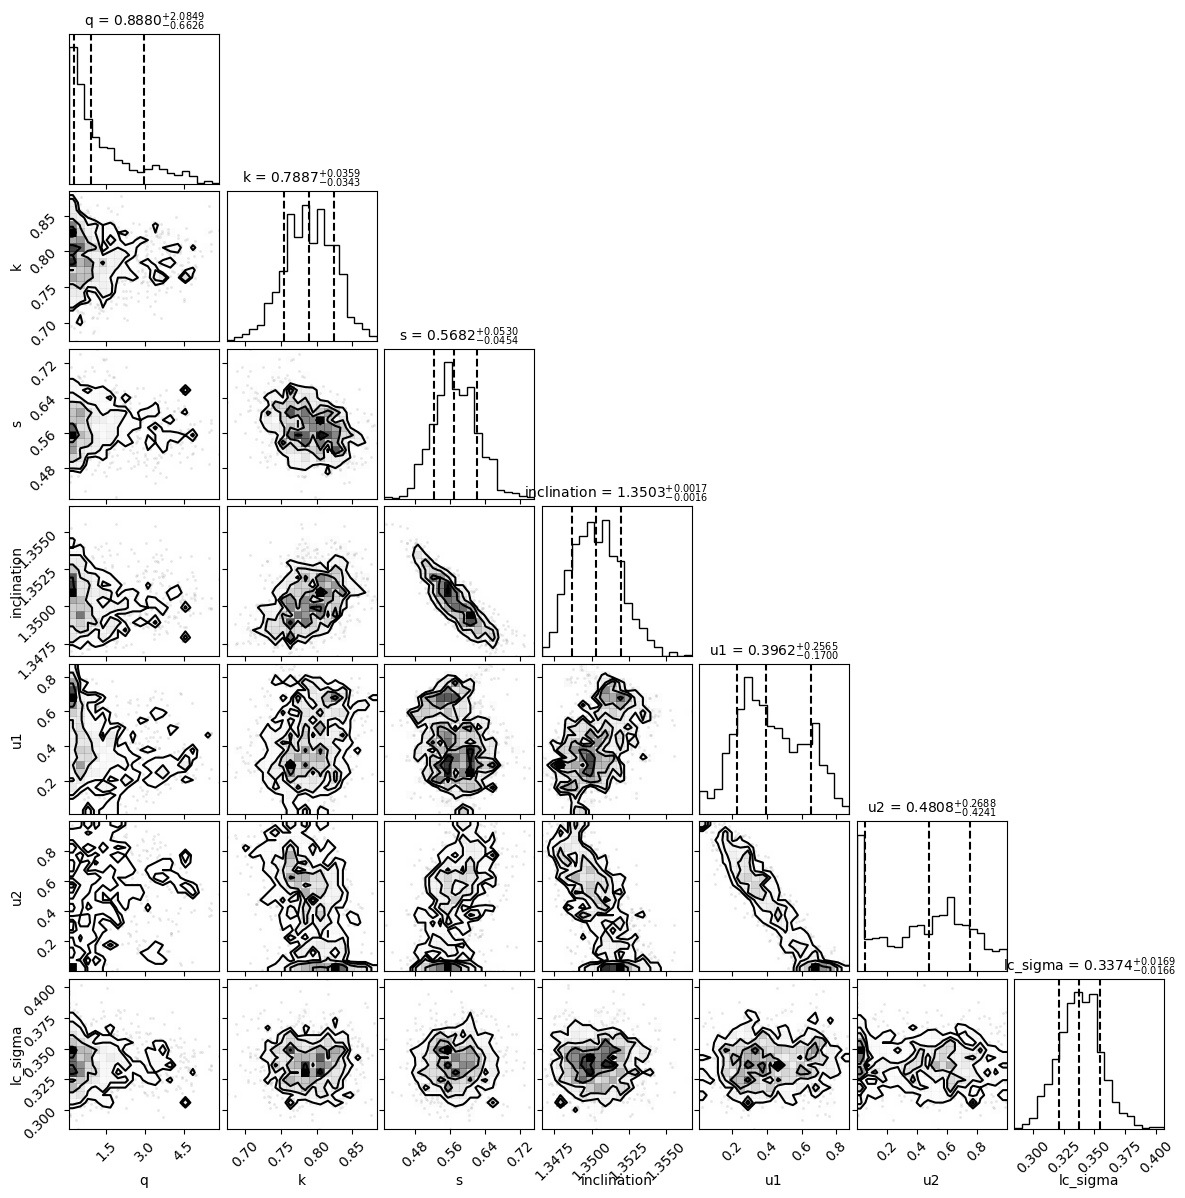

In [304]:
import corner
import arviz

var_names = [
    "q",
    "k",
    "s",
    "inclination",
    "u1",
    "u2",
    "lc_sigma",
]

# var_names = [
#     "R1",
#     "M1",
#     "R2",
#     "M2",
# ]

inf_data = arviz.from_numpyro(sampler)

fig = plt.figure(figsize=(12, 12))
_ = corner.corner(
    inf_data,
    var_names=var_names,
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 10},
    label_kwargs={"fontsize": 10},
    title_fmt=".4f",
    fig=fig,
)

### Trying to understand why so slow

In [35]:
import arviz as az

n_prior_samples = 3000
prior_samples = numpyro.infer.Predictive(model, num_samples=n_prior_samples)(
    jax.random.PRNGKey(0), time, flux
)

# Let's make it into an arviz InferenceData object.
# To do so we'll first need to reshape the samples to be of shape (chains, draws, *shape)
converted_prior_samples = {
    f"{p}": np.expand_dims(prior_samples[p], axis=0) for p in prior_samples
}
prior_samples_inf_data = az.from_dict(converted_prior_samples)

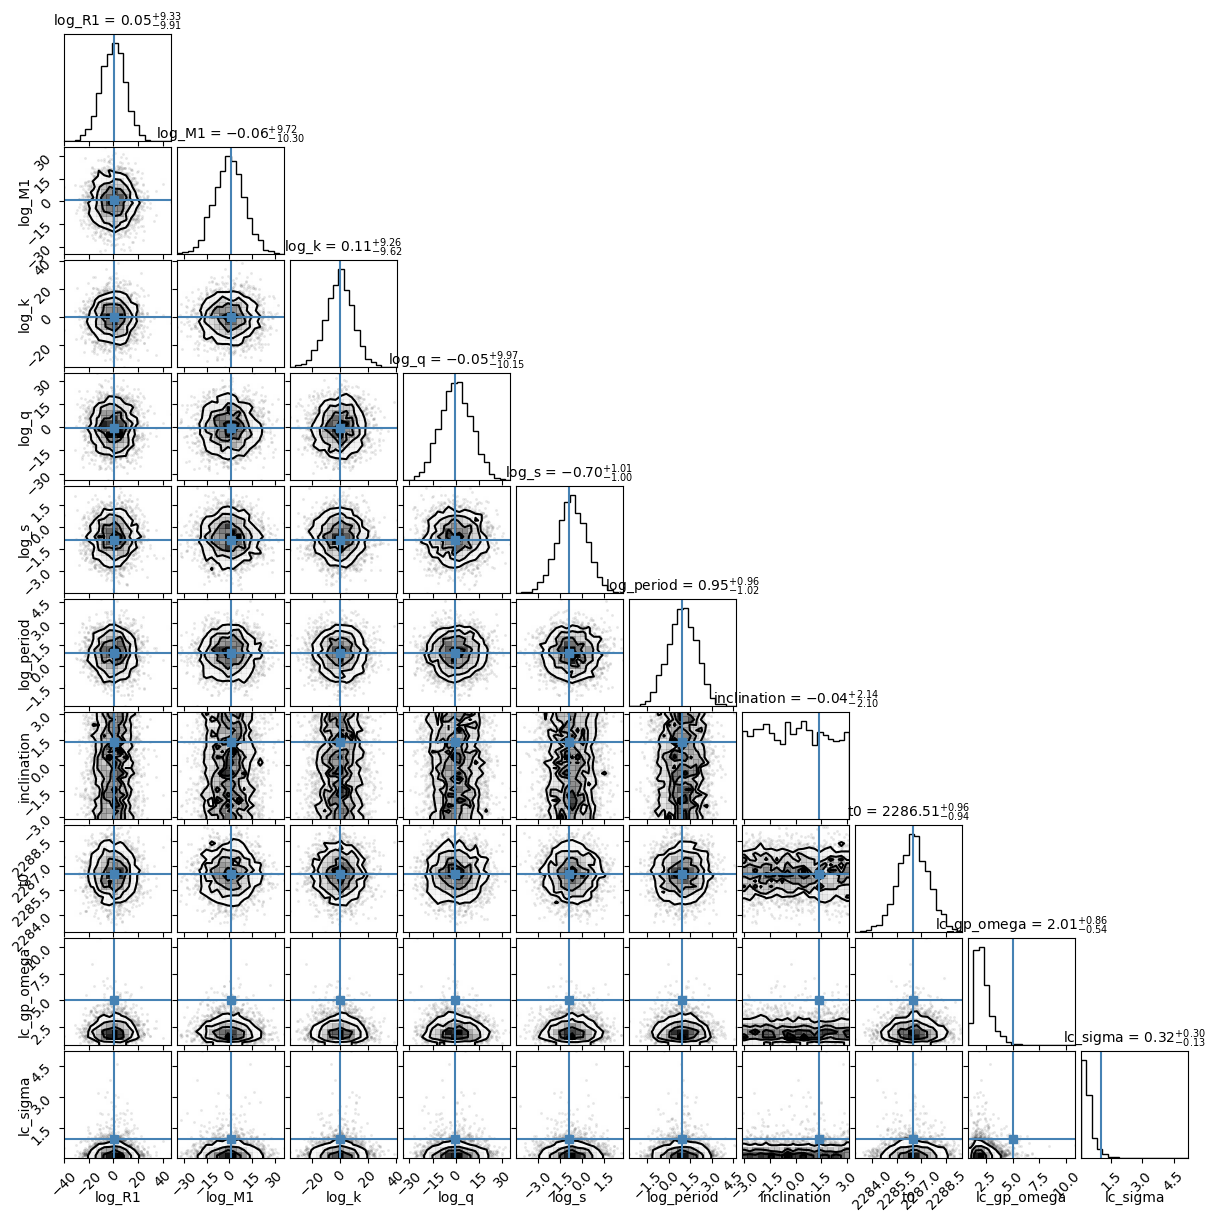

In [48]:
varnames = [
    "log_R1",
    "log_M1",
    "log_k",
    "log_q",
    "log_s",
    "log_period",
    "inclination",
    "t0",
    "lc_gp_omega",
    "lc_sigma",
]

# Plot the corner plot
fig = plt.figure(figsize=(12, 12))
_ = corner.corner(
    prior_samples_inf_data,
    fig=fig,
    var_names=varnames,
    truths=[opt_params[v] for v in varnames],
    show_titles=True,
    title_kwargs={"fontsize": 10},
    label_kwargs={"fontsize": 10},
)

In [28]:
%timeit logdensity_fn(initial_position).block_until_ready()

2.06 ms ± 13.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# No gp

In [227]:
import jax.numpy as jnp
from jaxoplanet.orbits import keplerian
from jaxoplanet.starry.orbit import SurfaceSystem, Surface
from jaxoplanet.light_curves.emission import light_curve
from jaxoplanet.light_curves.transforms import integrate
from tinygp import GaussianProcess, kernels
from jaxoplanet.units import unit_registry as ureg


def system_model(params):

    # from inferred parameters to system parameters
    R1 = jnp.exp(params["log_R1"]) * ureg.R_sun
    M1 = jnp.exp(params["log_M1"]) * ureg.M_sun
    R2 = jnp.exp(params["log_R1"] + params["log_k"]) * ureg.R_sun
    M2 = jnp.exp(params["log_M1"] + params["log_q"]) * ureg.M_sun
    period = jnp.exp(params["log_period"]) * ureg.day
    t0 = params["t0"] * ureg.day
    eccentricities = params["ecs"]
    eccentricity = jnp.sqrt(jnp.sum(eccentricities**2))
    omega = jnp.arctan2(eccentricities[1], eccentricities[0])
    inclination = params["inclination"] * ureg.rad
    s = jnp.exp(params["log_s"])
    u1 = params["u1"]
    u2 = params["u2"]

    primary = keplerian.Central(radius=R1, mass=M1)
    primary_surface = Surface(u=(u1, u2), amplitude=1.0, normalize=False)
    secondary_surface = Surface(amplitude=s, normalize=False)

    system = SurfaceSystem(primary, primary_surface).add_body(
        radius=R2,
        mass=M2,
        period=period,
        time_transit=t0,
        eccentricity=eccentricity,
        omega_peri=omega,
        inclination=inclination,
        surface=secondary_surface,
    )

    return system


def light_curve_model(time, params):

    system = system_model(params)

    flux = 1e3 * (
        (jnp.sum(light_curve(system)(time), 1)) / (1 + jnp.exp(params["log_s"])) - 1.0
    )

    return flux

## bayesian model

In [228]:
from scipy.optimize import root
from scipy.special import gammaincc


def estimate_inverse_gamma_parameters(
    lower, upper, target=0.01, initial=None, **kwargs
):
    r"""Estimate an inverse Gamma with desired tail probabilities
    This method numerically solves for the parameters of an inverse Gamma
    distribution where the tails have a given probability. In other words
    :math:`P(x < \mathrm{lower}) = \mathrm{target}` and similarly for the
    upper bound. More information can be found in `part 4 of this blog post
    <https://betanalpha.github.io/assets/case_studies/gp_part3/part3.html>`_.
    Args:
        lower (float): The location of the lower tail
        upper (float): The location of the upper tail
        target (float, optional): The desired tail probability
        initial (ndarray, optional): An initial guess for the parameters
            ``alpha`` and ``beta``
    Raises:
        RuntimeError: If the solver does not converge.
    Returns:
        dict: A dictionary with the keys ``alpha`` and ``beta`` for the
        parameters of the distribution.
    """
    lower, upper = np.sort([lower, upper])
    if initial is None:
        initial = np.array([2.0, 0.5 * (lower + upper)])
    if np.shape(initial) != (2,) or np.any(np.asarray(initial) <= 0.0):
        raise ValueError("invalid initial guess")

    def obj(x):
        a, b = np.exp(x)
        return np.array(
            [
                gammaincc(a, b / lower) - target,
                1 - gammaincc(a, b / upper) - target,
            ]
        )

    result = root(obj, np.log(initial), method="hybr", **kwargs)
    if not result.success:
        raise RuntimeError(
            "failed to find parameter estimates: \n{0}".format(result.message)
        )
    return dict(zip(("concentration", "rate"), np.exp(result.x)))

In [232]:
from jax import numpy as jnp
import numpyro
from numpyro.distributions import Normal, InverseGamma, Uniform
import numpyro_ext


def model(time, flux):
    # Parameters describing the primary
    log_M1 = numpyro.sample("log_M1", Normal(0.0, 10.0))
    log_R1 = numpyro.sample("log_R1", Normal(0.0, 10.0))
    u1 = numpyro.sample("u1", Uniform(0.0, 1.0))
    u2 = numpyro.sample("u2", Uniform(0.0, 1.0))

    # Secondary ratios
    log_radius_ratio = numpyro.sample("log_k", Normal(0.0, 10.0))  # radius ratio
    log_mass_ratio = numpyro.sample("log_q", Normal(0.0, 10.0))  # mass ratio
    log_flux_ratio = numpyro.sample("log_s", Normal(np.log(0.5), 1.0))  # flux ratio

    numpyro.deterministic("k", jnp.exp(log_radius_ratio))
    numpyro.deterministic("q", jnp.exp(log_mass_ratio))
    numpyro.deterministic("s", jnp.exp(log_flux_ratio))

    # Prior on flux ratio
    numpyro.sample(
        "flux_prior",
        Normal(*literature_flux_ratio),
        obs=jnp.exp(2 * log_radius_ratio + log_flux_ratio),
    )

    # Parameters describing the orbit
    log_period = numpyro.sample("log_period", Normal(np.log(literature_period), 1.0))
    t0 = numpyro.sample("t0", Normal(literature_t0, 1.0))

    # Parameters describing the eccentricity: ecs = [e * cos(w), e * sin(w)]
    ecs = numpyro.sample("ecs", numpyro_ext.distributions.UnitDisk())
    # inclination = numpyro.sample("inclination", numpyro_ext.distributions.Angle())
    inclination = numpyro.deterministic("inclination", 1.365)

    # light curve gp
    lc_gp_omega = numpyro.sample(
        "lc_gp_omega", InverseGamma(**estimate_inverse_gamma_parameters(1.0, 5.0))
    )
    lc_gp_sigma = numpyro.sample(
        "lc_gp_sigma",
        InverseGamma(**estimate_inverse_gamma_parameters(1.0, 5.0)),
    )
    lc_gp_quality = numpyro.deterministic("lc_gp_quality", 1 / 3)

    # error
    lc_sigma = numpyro.sample(
        "lc_sigma", InverseGamma(**estimate_inverse_gamma_parameters(0.1, 2.0))
    )

    model_params = {
        "log_M1": log_M1,
        "log_R1": log_R1,
        "log_q": log_mass_ratio,
        "log_k": log_radius_ratio,
        "log_period": log_period,
        "log_flux_ratio": log_flux_ratio,
        "inclination": inclination,
        "ecs": ecs,
        "log_s": log_flux_ratio,
        "t0": t0,
        "u1": u1,
        "u2": u2,
        "lc_gp_sigma": lc_gp_sigma,
        "lc_gp_omega": lc_gp_omega,
        "lc_gp_quality": lc_gp_quality,
        "lc_sigma": lc_sigma,
    }

    lc = light_curve_model(time, model_params)
    numpyro.sample("gp", Normal(lc, lc_sigma), obs=flux)

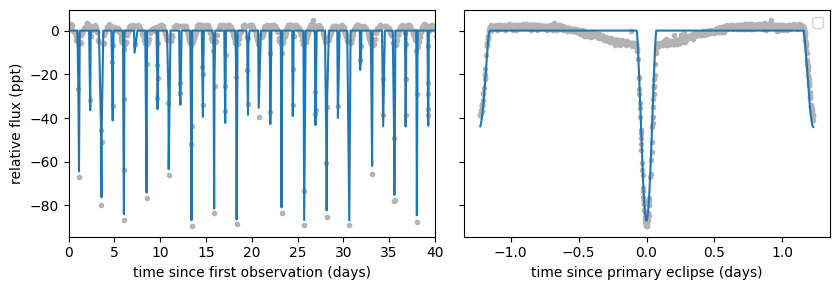

In [233]:
init_values = {
    "log_M1": np.log(2.24),
    "log_R1": np.log(1.758),
    "log_q": np.log(1.570 / 2.24),
    "log_k": np.log(1.508 / 1.758),
    "log_period": np.log(literature_period),
    "inclination": 1.365,
    "log_s": np.log(0.354),
    "t0": literature_t0,
    "ecs": np.array([1e-5, 0.0]),
    "u1": 0.2,
    "u2": 0.2,
    "lc_gp_sigma": 3.0,
    "lc_gp_omega": 5.0,
    "lc_gp_quality": 1 / 3,
    "lc_sigma": 1.0,
    "mean_lc": 0.0,
}

lc = light_curve_model(time, init_values)
phase = (
    time - literature_t0 + 0.5 * literature_period
) % literature_period - 0.5 * literature_period
fig, axes = plt.subplots(1, 2, figsize=(8.5, 3), sharey=True)
idxs = np.argsort(phase)

plt.subplot(121)
plt.plot(time - time.min(), flux, ".", c="0.7")
plt.plot(time - time.min(), lc, label="mean", c="C0")
plt.xlabel("time since first observation (days)")
plt.ylabel("relative flux (ppt)")
plt.xlim(0, 40)

plt.subplot(122)
plt.plot(phase, flux, ".", c="0.7")
plt.xlabel("time since primary eclipse (days)")
plt.plot(phase[idxs], lc[idxs], c="C0")
plt.legend()
plt.tight_layout()

In [234]:
opt_params = numpyro_ext.optim.optimize(model, start=init_values)(
    jax.random.PRNGKey(0), time, flux
)

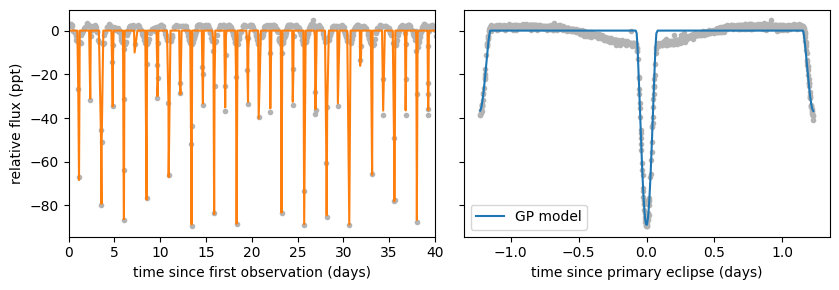

In [235]:
phase_pred = (
    time - opt_params["t0"] + 0.5 * np.exp(opt_params["log_period"])
) % np.exp(opt_params["log_period"]) - 0.5 * np.exp(opt_params["log_period"])

lc = light_curve_model(time, opt_params)

fig, axes = plt.subplots(1, 2, figsize=(8.5, 3), sharey=True)
plt.subplot(121)
plt.plot(time - time.min(), flux, ".", c="0.7")
plt.plot(time - time.min(), lc, label="mean", c="C1")
plt.xlabel("time since first observation (days)")
plt.ylabel("relative flux (ppt)")
plt.xlim(0, 40)

idxs = np.argsort(phase_pred)
plt.subplot(122)
plt.plot(phase_pred, flux, ".", c="0.7")
plt.xlabel("time since primary eclipse (days)")
plt.plot(phase_pred[idxs], lc[idxs], c="C0", label="GP model")
plt.legend()
plt.tight_layout()

## sampling

In [236]:
from numpyro import infer

sampler = infer.MCMC(
    infer.NUTS(
        model,
        init_strategy=infer.init_to_value(values=opt_params),
        dense_mass=True,
        regularize_mass_matrix=False,
    ),
    num_warmup=200,
    num_samples=2000,
    progress_bar=True,
    num_chains=1,
)

sampler.run(jax.random.PRNGKey(6), time, flux)

sample:  36%|███▌      | 782/2200 [08:36<15:36,  1.51it/s, 1023 steps of size 9.09e-03. acc. prob=0.90]


KeyboardInterrupt: 

# Combined model

In [2]:
import jax
import numpyro

numpyro.set_host_device_count(2)
jax.config.update("jax_enable_x64", True)

literature_period = 2.46113408
literature_t0 = 119.522070 + 2457000 - 2454833

# Prior on the flux ratio for Kepler
literature_flux_ratio = (0.354, 0.035)

## Data

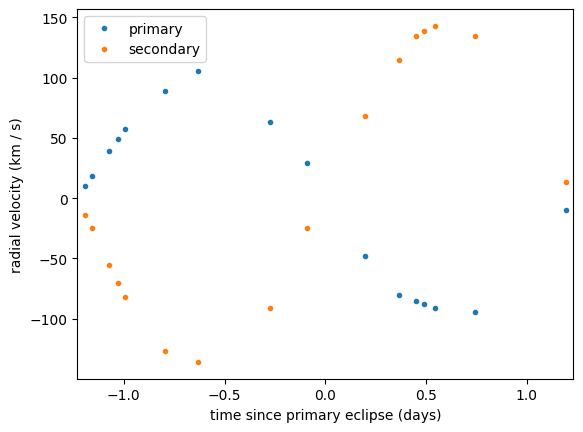

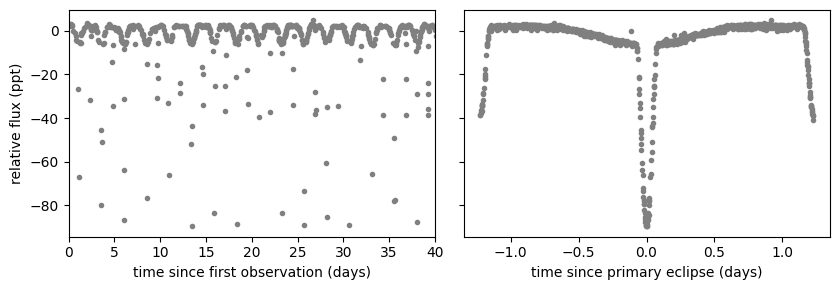

In [109]:
import numpy as np
import matplotlib.pyplot as plt

ref1 = 2453000
ref2 = 2400000
rvs = np.array(
    [
        # https://arxiv.org/abs/astro-ph/0403444
        (39.41273 + ref1, -85.0, 134.5),
        (39.45356 + ref1, -88.0, 139.0),
        (39.50548 + ref1, -91.0, 143.0),
        (43.25049 + ref1, 105.5, -136.0),
        (46.25318 + ref1, 29.5, -24.5),
        # https://ui.adsabs.harvard.edu/abs/2007A%26A...463..579G/abstract
        (52629.6190 + ref2, 88.8, -127.0),
        (52630.6098 + ref2, -48.0, 68.0),
        (52631.6089 + ref2, -9.5, 13.1),
        (52632.6024 + ref2, 63.6, -90.9),
        (52633.6162 + ref2, -94.5, 135.0),
        (52636.6055 + ref2, 10.3, -13.9),
        (52983.6570 + ref2, 18.1, -25.1),
        (52987.6453 + ref2, -80.6, 114.5),
        (52993.6322 + ref2, 49.0, -70.7),
        (53224.9338 + ref2, 39.0, -55.7),
        (53229.9384 + ref2, 57.2, -82.0),
    ]
)
rvs[:, 0] -= 2454833
rvs = rvs[np.argsort(rvs[:, 0])]

time_rvs = np.ascontiguousarray(rvs[:, 0], dtype=np.float64)
obs_rv1 = np.ascontiguousarray(rvs[:, 1], dtype=np.float64)
obs_rv2 = np.ascontiguousarray(rvs[:, 2], dtype=np.float64)

phase_rvs = (
    time_rvs - literature_t0 + 0.5 * literature_period
) % literature_period - 0.5 * literature_period

plt.figure()
plt.plot(phase_rvs, rvs[:, 1], ".", label="primary")
plt.plot(phase_rvs, rvs[:, 2], ".", label="secondary")
plt.legend(fontsize=10)
plt.xlim(-0.5 * literature_period, 0.5 * literature_period)
plt.ylabel("radial velocity (km / s)")
_ = plt.xlabel("time since primary eclipse (days)")

import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk

tpf = lk.search_targetpixelfile("EPIC 211082420").download()
lc = tpf.to_lightcurve(aperture_mask="all")
lc = lc.remove_nans().normalize()

hdr = tpf.hdu[1].header
exposure = hdr["FRAMETIM"] * hdr["NUM_FRM"]
exposure /= 60.0 * 60.0 * 24.0

# To keep things fast for this example, we're only going to use a third of the data
np.random.seed(68594)
m = np.random.rand(len(lc.time)) < 1.0 / 3

time = lc.time.value[m]
flux = lc.flux[m]
flux = flux / np.median(flux) - 1
flux = flux.value * 1e3  # ppt

phase = (
    time - literature_t0 + 0.5 * literature_period
) % literature_period - 0.5 * literature_period

fig, axes = plt.subplots(1, 2, figsize=(8.5, 3), sharey=True)

plt.subplot(121)
plt.plot(time - time.min(), flux, ".", c="0.5")
plt.xlabel("time since first observation (days)")
plt.ylabel("relative flux (ppt)")
plt.xlim(0, 40)

plt.subplot(122)
plt.plot(phase, flux, ".", c="0.5")
plt.xlabel("time since primary eclipse (days)")

plt.tight_layout()

## Model

In [142]:
import jax.numpy as jnp
from jaxoplanet.orbits import keplerian
from jaxoplanet.starry.orbit import SurfaceSystem, Surface
from jaxoplanet.starry.light_curves import light_curve
from jaxoplanet.light_curves.transforms import integrate
from tinygp import GaussianProcess, kernels
from jaxoplanet.units import unit_registry as ureg


def system_model(params):

    # from inferred parameters to system parameters
    R1 = jnp.exp(params["log_R1"]) * ureg.R_sun
    M1 = jnp.exp(params["log_M1"]) * ureg.M_sun
    R2 = jnp.exp(params["log_R1"] + params["log_k"]) * ureg.R_sun
    M2 = jnp.exp(params["log_M1"] + params["log_q"]) * ureg.M_sun
    period = jnp.exp(params["log_period"]) * ureg.day
    t0 = params["t0"] * ureg.day
    eccentricities = params["ecs"]
    eccentricity = jnp.sqrt(jnp.sum(eccentricities**2))
    omega = jnp.arctan2(eccentricities[1], eccentricities[0])
    inclination = params["inclination"] * ureg.rad
    s = jnp.exp(params["log_s"])
    u1 = params["u1"]
    u2 = params["u2"]

    primary = keplerian.Central(radius=R1, mass=M1)
    primary_surface = Surface(u=(u1, u2), amplitude=1.0, normalize=False)
    secondary_surface = Surface(amplitude=s, normalize=False)

    system = SurfaceSystem(primary, primary_surface).add_body(
        radius=R2,
        mass=M2,
        period=period,
        time_transit=t0,
        eccentricity=eccentricity,
        omega_peri=omega,
        inclination=inclination,
        surface=secondary_surface,
    )

    return system


def light_curve_model(time, system, params):

    system = system_model(params)

    def flux_function(time):
        flux = (
            1e3
            * (
                (jnp.sum(light_curve(system)(time))) / (1 + jnp.exp(params["log_s"]))
                - 1.0
            )
            + params["mean_lc"]
        )

        return flux

    gp = GaussianProcess(
        kernels.quasisep.SHO(
            sigma=params["lc_gp_sigma"],
            omega=params["lc_gp_omega"],
            quality=params["lc_gp_quality"],
        ),
        time,
        mean=flux_function,
        diag=params["lc_sigma"] ** 2,
    )

    return gp


def rv_model(time, system, params):
    mass_ratio = jnp.exp(params["log_q"])

    def rv1(time):
        return system.radial_velocity(time)[0].to("km / s").magnitude

    def rv2(time):
        return -system.radial_velocity(time)[1].to("km / s").magnitude / mass_ratio

    kernel = kernels.quasisep.SHO(
        sigma=params["rv_gp_sigma"],
        omega=params["rv_gp_omega"],
        quality=params["rv_gp_quality"],
    )

    gp_rv1 = GaussianProcess(
        kernel,
        time,
        mean=rv1,
        diag=params["rv1_sigma"] ** 2,
    )

    gp_rv2 = GaussianProcess(
        kernel,
        time,
        mean=rv2,
        diag=params["rv2_sigma"] ** 2,
    )

    return gp_rv1, gp_rv2

In [143]:
from jax import numpy as jnp
import numpyro
from numpyro.distributions import Normal, InverseGamma, Uniform
import numpyro_ext


def model():
    # SYSTEM
    # ------
    # Parameters describing the primary
    log_M1 = numpyro.sample("log_M1", Normal(0.0, 10.0))
    log_R1 = numpyro.sample("log_R1", Normal(0.0, 10.0))
    u1 = numpyro.sample("u1", Uniform(0.0, 1.0))
    u2 = numpyro.sample("u2", Uniform(0.0, 1.0))

    # Secondary ratios
    log_radius_ratio = numpyro.sample("log_k", Normal(0.0, 10.0))  # radius ratio
    log_mass_ratio = numpyro.sample("log_q", Normal(0.0, 10.0))  # mass ratio
    log_flux_ratio = numpyro.sample("log_s", Normal(np.log(0.5), 10.0))  # flux ratio
    numpyro.deterministic("k", jnp.exp(log_radius_ratio))
    numpyro.deterministic("q", jnp.exp(log_mass_ratio))
    numpyro.deterministic("s", jnp.exp(log_flux_ratio))

    numpyro.deterministic("R1", jnp.exp(log_R1))
    numpyro.deterministic("M1", jnp.exp(log_M1))
    numpyro.deterministic("R2", jnp.exp(log_R1 + log_radius_ratio))
    numpyro.deterministic("M2", jnp.exp(log_M1 + log_mass_ratio))

    # Prior on flux ratio
    numpyro.sample(
        "flux_prior",
        Normal(*literature_flux_ratio),
        obs=jnp.exp(2 * log_radius_ratio + log_flux_ratio),
    )

    # Parameters describing the orbit
    log_period = numpyro.sample("log_period", Normal(np.log(literature_period), 1.0))
    t0 = numpyro.sample("t0", Normal(literature_t0, 1.0))

    # Parameters describing the eccentricity: ecs = [e * cos(w), e * sin(w)]
    ecs = numpyro.sample("ecs", numpyro_ext.distributions.UnitDisk())
    inclination = numpyro.sample("inclination", numpyro_ext.distributions.Angle())

    system_params = {
        "log_M1": log_M1,
        "log_R1": log_R1,
        "log_q": log_mass_ratio,
        "log_k": log_radius_ratio,
        "log_period": log_period,
        "log_flux_ratio": log_flux_ratio,
        "inclination": inclination,
        "ecs": ecs,
        "log_s": log_flux_ratio,
        "t0": t0,
        "u1": u1,
        "u2": u2,
    }

    system = system_model(system_params)

    # RADIAL VELOCITY
    # ---------------
    mean_rv = numpyro.sample("mean_rv", Normal(0.0, 10.0))
    rv_gp_omega = numpyro.sample(
        "rv_gp_omega", InverseGamma(**estimate_inverse_gamma_parameters(1.0, 25.0))
    )
    rv_gp_sigma = numpyro.sample(
        "rv_gp_sigma", InverseGamma(**estimate_inverse_gamma_parameters(1.0, 5.0))
    )

    rv1_sigma = numpyro.sample(
        "rv1_sigma", InverseGamma(**estimate_inverse_gamma_parameters(0.5, 5.0))
    )
    rv2_sigma = numpyro.sample(
        "rv2_sigma", InverseGamma(**estimate_inverse_gamma_parameters(0.5, 5.0))
    )

    rv_gp_quality = numpyro.deterministic("rv_gp_quality", 1 / 3)

    rv_params = {
        "mean_rv": mean_rv,
        "rv_gp_omega": rv_gp_omega,
        rv_gp_quality: rv_gp_quality,
        "rv_gp_sigma": rv_gp_sigma,
        "rv1_sigma": rv1_sigma,
        "rv2_sigma": rv2_sigma,
        **system_params,
    }

    gp_rv1, gp_rv2 = rv_model(time_rvs, system, rv_params)

    numpyro.sample("rv1", gp_rv1.numpyro_dist(), obs=obs_rv1)
    numpyro.sample("rv2", gp_rv2.numpyro_dist(), obs=obs_rv2)

    # LIGHT CURVE
    # -----------

    # light curve gp
    lc_gp_omega = numpyro.sample(
        "lc_gp_omega", InverseGamma(**estimate_inverse_gamma_parameters(1.0, 5.0))
    )
    lc_gp_sigma = numpyro.sample(
        "lc_gp_sigma",
        InverseGamma(**estimate_inverse_gamma_parameters(1.0, 5.0)),
    )
    lc_gp_quality = numpyro.deterministic("lc_gp_quality", 1 / 3)

    # light curve error
    lc_sigma = numpyro.sample(
        "lc_sigma", InverseGamma(**estimate_inverse_gamma_parameters(0.1, 2.0))
    )

    mean_lc = numpyro.sample("mean_lc", Normal(0.0, 10.0))

    lc_params = {
        "lc_gp_sigma": lc_gp_sigma,
        "lc_gp_omega": lc_gp_omega,
        "lc_gp_quality": lc_gp_quality,
        "lc_sigma": lc_sigma,
        "mean_lc": mean_lc,
        **system_params,
    }

    gp = light_curve_model(time, system, lc_params)
    numpyro.sample("gp", gp.numpyro_dist(), obs=flux)
    numpyro.deterministic("mean", gp.mean)

## optimization

In [144]:
init_params = {
    "log_M1": np.log(2.24),
    "log_R1": np.log(1.758),
    "log_q": np.log(1.570 / 2.24),
    "log_k": np.log(1.508 / 1.758),
    "log_period": np.log(literature_period),
    "inclination": 1.365,
    "log_s": np.log(0.354),
    "t0": literature_t0,
    "ecs": np.array([1e-5, 0.0]),
    "u1": 0.2,
    "u2": 0.2,
    "lc_gp_sigma": 5.0,
    "lc_gp_omega": 5.0,
    "lc_gp_quality": 13,
    "lc_sigma": 1.0,
    "mean_lc": 0.0,
    # RV
    "mean_rv": 0.0,
    "rv_gp_omega": 5.0,
    "rv_gp_sigma": 2.5,
    "rv1_sigma": 1.0,
    "rv2_sigma": 1.0,
    "rv_gp_quality": 1 / 3,
}

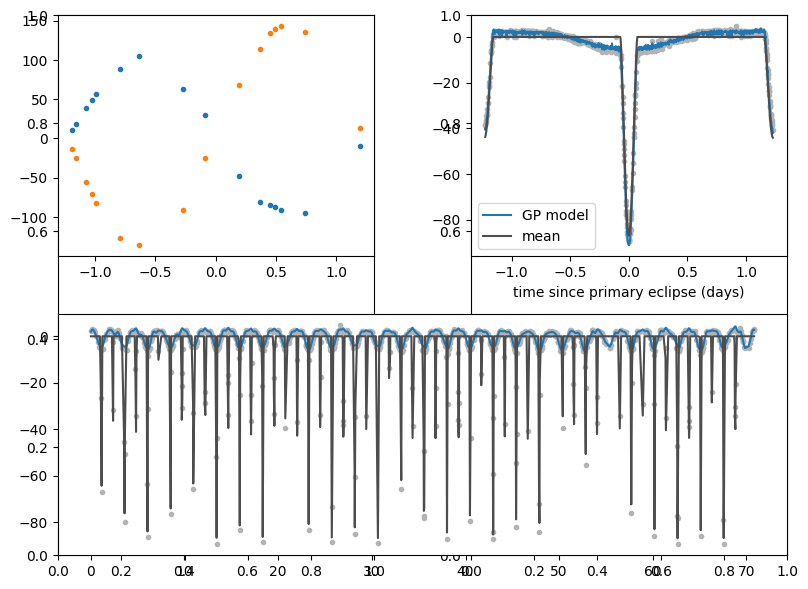

In [145]:
opt_params = init_params.copy()
period = jnp.exp(opt_params["log_period"])
t0 = opt_params["t0"]

rv_model_phase = np.linspace(-0.5 * period, 0.5 * period, 500)
system = system_model(opt_params)
mrv1, mrv2 = rv_model(rv_model_phase + t0, system, opt_params)
gp = light_curve_model(time, system, opt_params)
gprv1, gprv2 = rv_model(time_rvs, system, opt_params)

phase_rvs = (time_rvs - t0 + 0.5 * period) % period - 0.5 * period
phase_lc = (time - t0 + 0.5 * period) % period - 0.5 * period

fig, axes = plt.subplots(1, 2, figsize=(8.5, 6))

plt.subplot(2, 2, 1)
plt.plot(phase_rvs, rvs[:, 1], ".", color="C0", label="primary")
plt.plot(phase_rvs, rvs[:, 2], ".", color="C1", label="secondary")
plt.plot(
    rv_model_phase, gprv1.condition(obs_rv1, rv_model_phase).gp.loc, "-", color="C0"
)
# plt.plot(rv_model_phase, mrv2, "-", color="C1")
# plt.ylabel("radial velocity (km/s)")
# plt.xlabel("time since primary eclipse (days)")
# plt.legend()

plt.subplot(2, 2, 2)
idxs = np.argsort(phase_lc)
plt.plot(phase_lc, flux, ".", c="0.7")
plt.xlabel("time since primary eclipse (days)")
plt.plot(phase_lc[idxs], gp.condition(flux).gp.loc[idxs], c="C0", label="GP model")
plt.plot(phase_lc[idxs], gp.mean[idxs], c="0.3", label="mean")
plt.legend()
plt.tight_layout()

plt.subplot(2, 2, (3, 4))
plt.plot(time - time.min(), flux, ".", c="0.7")
plt.plot(
    time - time.min(),
    gp.condition(flux, include_mean=False).gp.loc,
    label="mean",
    c="C0",
)
plt.plot(time - time.min(), gp.mean, label="mean", c="0.3")

In [147]:
gprv1

GaussianProcess(
  num_data=16,
  dtype=dtype('float64'),
  kernel=SHO(omega=5.0, quality=0.3333333333333333, sigma=2.5),
  X=f64[16](numpy),
  mean_function=Mean(value=None, func=<function rv1>),
  mean=f64[16],
  noise=Diagonal(diag=f64[16]),
  solver=QuasisepSolver(
    X=f64[16](numpy),
    matrix=SymmQSM(
      diag=DiagQSM(d=f64[16]),
      lower=StrictLowerTriQSM(p=f64[16,2], q=f64[16,2], a=f64[16,2,2])
    ),
    factor=LowerTriQSM(
      diag=DiagQSM(d=f64[16]),
      lower=StrictLowerTriQSM(p=f64[16,2], q=f64[16,2], a=f64[16,2,2])
    )
  )
)

: 

In [114]:
from tqdm import tqdm

key = jax.random.PRNGKey(0)

params_opt = [
    ["log_q", "mean_rv"],
    ["inclination", "log_k", "log_s", "log_R1", "mean_lc", "log_period", "t0"],
    ["lc_gp_sigma", "lc_gp_omega", "lc_sigma", "mean_lc"],
    ["ecs", "log_q", "mean_rv"],
    None,
]

mask = np.ones(len(time), dtype=bool)

for _ in tqdm(range(5)):
    opt_params = init_params.copy()
    for params in params_opt:
        opt_params = numpyro_ext.optim.optimize(model, start=opt_params, sites=params)(
            key
        )
    system = system_model(opt_params)
    gp = light_curve_model(time[mask], system, opt_params)
    residuals = np.abs(flux - gp.condition(flux[mask], time).gp.loc)
    mask = mask & (residuals < 7 * np.std(residuals[mask]))

100%|██████████| 5/5 [02:33<00:00, 30.69s/it]


## sampling

In [116]:
from numpyro import infer

sampler = infer.MCMC(
    infer.NUTS(
        model,
        init_strategy=infer.init_to_value(values=opt_params),
        dense_mass=True,
        regularize_mass_matrix=False,
        target_accept_prob=0.95,
    ),
    num_warmup=1000,
    num_samples=2000,
    progress_bar=True,
    num_chains=2,
)

sampler.run(jax.random.PRNGKey(6))

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

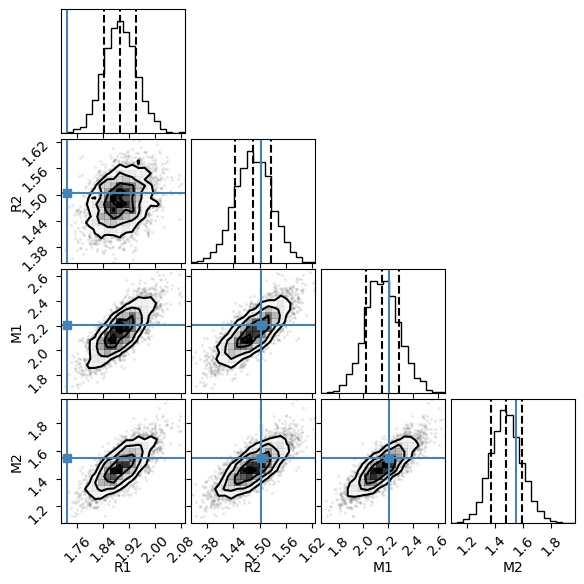

In [119]:
import corner
import arviz

inf_data = arviz.from_numpyro(sampler)

fig = plt.figure(figsize=(6, 6))
_ = corner.corner(
    inf_data,
    var_names=["R1", "R2", "M1", "M2"],
    truths=[1.727, 1.503, 2.203, 1.5488],
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 10},
    label_kwargs={"fontsize": 10},
    title_fmt=".4f",
    fig=fig,
)

In [125]:
arviz.summary(inf_data, var_names=["M1", "M2", "R1", "R2", "ecs", "inclination", "s"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
M1,2.152,0.140,1.883,2.412,0.003,0.002,2997.0,2525.0,1.0
M2,1.480,0.112,1.274,1.690,0.002,0.001,3294.0,2823.0,1.0
R1,1.892,0.051,1.799,1.991,0.001,0.001,2387.0,1862.0,1.0
R2,1.485,0.042,1.402,1.561,0.001,0.001,2991.0,2506.0,1.0
ecs[0],0.000,0.000,0.000,0.000,0.000,0.000,4483.0,3216.0,1.0
ecs[1],0.083,0.009,0.066,0.100,0.000,0.000,949.0,1499.0,1.0
inclination,1.350,0.001,1.348,1.352,0.000,0.000,385.0,413.0,1.0
s,0.592,0.037,0.525,0.659,0.001,0.001,983.0,2252.0,1.0


In [120]:
samples = sampler.get_samples()

In [121]:
inferred_params = {key: np.median(samples[key], 0) for key in init_params.keys()}

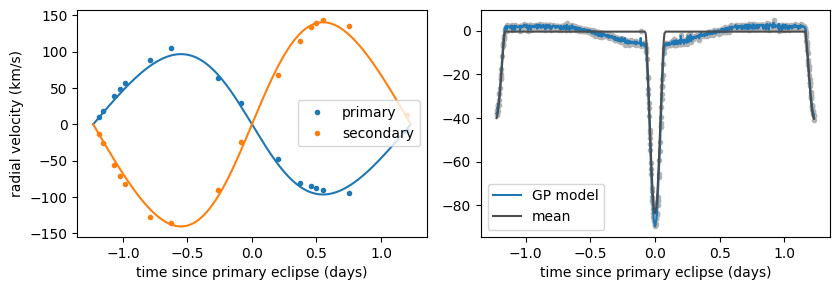

In [122]:
period = jnp.exp(inferred_params["log_period"])
t0 = inferred_params["t0"]

rv_model_phase = np.linspace(-0.5 * period, 0.5 * period, 500)
system = system_model(inferred_params)
mrv1, mrv2 = rv_model(rv_model_phase + t0, system, inferred_params)
gp = light_curve_model(time, system, inferred_params)

phase_rvs = (time_rvs - t0 + 0.5 * period) % period - 0.5 * period
phase_lc = (time - t0 + 0.5 * period) % period - 0.5 * period

fig, axes = plt.subplots(1, 2, figsize=(8.5, 3))

plt.subplot(121)
plt.plot(phase_rvs, rvs[:, 1], ".", color="C0", label="primary")
plt.plot(phase_rvs, rvs[:, 2], ".", color="C1", label="secondary")
plt.plot(rv_model_phase, mrv1, "-", color="C0")
plt.plot(rv_model_phase, mrv2, "-", color="C1")
plt.ylabel("radial velocity (km/s)")
plt.xlabel("time since primary eclipse (days)")
plt.legend()

plt.subplot(122)
idxs = np.argsort(phase_lc)
plt.plot(phase_lc, flux, ".", c="0.7")
plt.xlabel("time since primary eclipse (days)")
plt.plot(phase_lc[idxs], gp.condition(flux).gp.loc[idxs], c="C0", label="GP model")
plt.plot(phase_lc[idxs], gp.mean[idxs], c="0.3", label="mean")
plt.legend()
plt.tight_layout()